In [1]:
import pandas as pd
import re
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_latlon(s):
    ''' Parse a string s which contains either a longitude or a latitude and convert it into Degree Minute Second vector'''
    
    if len(s.split('°')) >1:
        deg = s.split('°')[0]
        rest = s.split('°')[1].strip()
        if len(rest.split("''"))>1:
            rest = rest.split("''")[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [deg,minute,sec]
        elif len(rest.split('"'))>1:
            rest = rest.split('"')[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [float(deg),float(minute),float(sec)]
        elif len(rest.split("'"))>1:
            minute = rest.split("'")[0]
            return [float(deg),float(minute),None]
        elif len(rest) == 0:
            return [float(deg),None,None]


def dms_to_dd(data):
    ''' Converts Degree Minute Second vector into Decimal Degrees coordinates'''
    
    return pd.Series(np.nansum([data['degrees'],np.sign(data['degrees'])*data['minutes']/60.,np.sign(data['degrees'])*data['seconds']/3600],axis=0),index=['lat','lon'])

def convert(s):
    ''' Convert a coordinate string s into a pandas Series of latitude and longitude in Decimal Degrees format'''
    try:
        pat = "^,*\s*"
        p = re.compile(pat)
        if len(s.split('N'))>1:
            latstr = s.split('N')[0]
            lonstr = re.sub(p,'',s.split('N')[1])
        elif len(s.split('S'))>1:
            latstr = s.split('S')[0]
            lonstr = re.sub(p,'',s.split('S')[1])
            latstr = '-'+latstr
        else:
             return None   
        if lonstr.find('W') != -1:
            lonstr = '-'+lonstr
        lonstr = lonstr.split('E')[0]
        lonstr = lonstr.split('W')[0]

        lat = np.array(parse_latlon(latstr))
        lon = np.array(parse_latlon(lonstr))
        res = dms_to_dd(pd.DataFrame([lat,lon],columns=['degrees','minutes','seconds']).astype(float))
    except Exception as e:
        res = 'error'
        return pd.Series([res,res],index=['lat','lon'])
    return res

1. Load raw data, merge synthetic coordinates and mark seperately the synthetic coordiantes and the region level coordinates

In [3]:
data = pd.read_excel('data/RawData.xlsx') #Read

data = data[data['aggregated biome'] != 'Shrubland/Grassland'] #reove sites with insufficient data

data.loc[~data['synthetic coordinates'].isna(),'coordinates'] = data.loc[~data['synthetic coordinates'].isna(),'synthetic coordinates'] #Merge
data.loc[~data['synthetic coordinates'].isna(),'synthetic'] = True #Mark sythetic
region_data = data['remarks'].str.contains('region|Country').dropna() #find region-level or country-level locations
data.loc[region_data[region_data].index,'region'] = True #mark region data

In [4]:
data.loc[data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
data.loc[data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
data.loc[data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
data.loc[data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
data.loc[data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

2. Find unique site-coordinate combinations 

In [5]:
#site_locations = data.loc[:,['site','coordinates']].drop_duplicates()
site_locations = data.loc[:,['site','coordinates','aggregated taxon','units']].drop_duplicates()
site_with_coords = site_locations[(~site_locations.coordinates.isna()) & (site_locations.coordinates != 0)]
site_with_coords = site_with_coords.merge(data.loc[~data['synthetic coordinates'].isna(),['synthetic','region']],left_index=True,right_index=True,how='left')

3. Convert string coordinates into latitudes and longitudes

In [6]:
site_with_coords[['lat','lon']] = site_with_coords.loc[:,'coordinates'].apply(convert)

In [11]:
site_with_coords

,site,coordinates,aggregated taxon,units,synthetic,region,lat,lon
0,Cat Tien National Park - Lagerstroemia forest,"11°25'43.0'' N, 107°25'38.7'' E",Collembola,individuals/m^2,NaN,NaN,11.4286,107.427
1,Cat Tien National Park - Riparian dipterocarp ...,"11°26'48.2'' N, 107°26'26.2'' E",Collembola,individuals/m^2,NaN,NaN,11.4467,107.441
2,Bi Dup-Nui Ba Nature Reserve - Mountain pine f...,"12°02'41.3'' N, 108°21'48.7'' E",Collembola,individuals/m^2,NaN,NaN,12.0448,108.364
3,Cat Tien National Park - Lagerstroemia forest,"11°25'43.0'' N, 107°25'38.7'' E",Other,individuals/m^2,NaN,NaN,11.4286,107.427
6,Cat Tien National Park - Riparian dipterocarp ...,"11°26'48.2'' N, 107°26'26.2'' E",Other,individuals/m^2,NaN,NaN,11.4467,107.441
...,...,...,...,...,...,...,...,...
8121,Gottinger Wald,"51°33'24.36''N, 10°1'16.94''E",Other,mg/m^2 (wet weight),NaN,NaN,51.5568,10.0214
8143,Jornada Validation Site,"32°38'24.69""N, 106°35'57.77""W",Collembola,individuals/m^2,True,NaN,32.6402,-106.599
8144,Jornada Validation Site,"32°38'24.69""N, 106°35'57.77""W",Acari,individuals/m^2,True,NaN,32.6402,-106.599
8153,Boreal forests and Taiga - Isoptera,"60° 0'0.00""N, 100° 0'0.00""E",Isoptera,mg/m^2 (wet weight),True,True,60,100


4. Mark each coordinate type in a different color

In [42]:
site_with_coords = site_with_coords[site_with_coords.lon!='error']

acc_coords = site_with_coords.loc[site_with_coords.synthetic.isna()]
syn_coords = site_with_coords.loc[~site_with_coords.synthetic.isna()]
region_coords = site_with_coords.loc[~site_with_coords.region.isna()]

5. Plot results

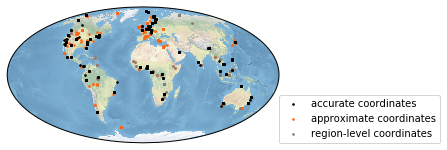

In [76]:
fig = plt.figure(figsize=(5,2.5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()

plt.scatter(syn_coords.lon.values, syn_coords.lat.values,
         color='#ff6512', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'approximate coordinates'
         )

plt.scatter(region_coords.lon.values, region_coords.lat.values,
         color='grey', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'region-level coordinates'
         )

plt.scatter(acc_coords.lon.values, acc_coords.lat.values,
         color='k', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'accurate coordinates'
         )

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(1,0))

#plt.tight_layout()

plt.savefig('results/fig1_all.svg',dpi=600,bbox_inches = "tight")##
plt.savefig('results/fig1_all.pdf',dpi=600,bbox_inches = "tight")##
plt.savefig('results/fig1_all.png',dpi=600,bbox_inches = "tight")##


plt.show()


6. Repeat for every aggregated taxon

TypeError: cannot unpack non-iterable PathCollection object

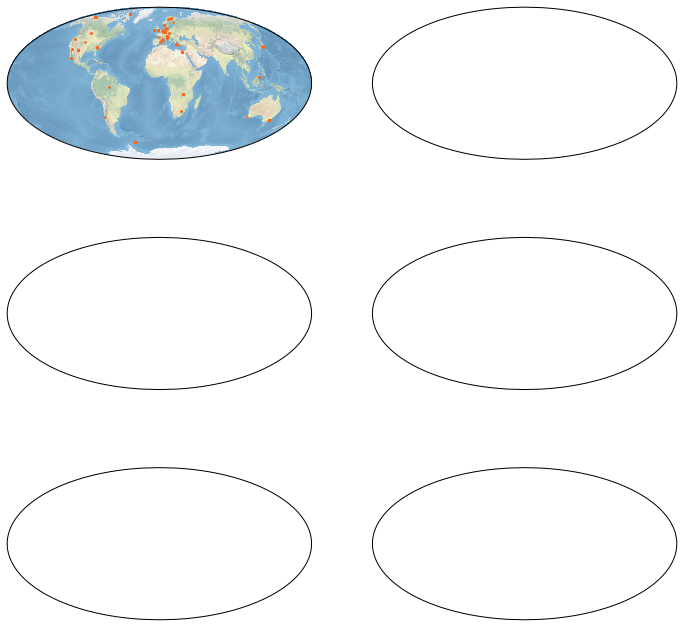

In [75]:
#def PlotScatt(x,Title):
def PlotScatt(x,ax,Title):
    
    
    acc_coords = x.loc[x.synthetic.isna()]
    syn_coords = x.loc[~x.synthetic.isna()]
    region_coords = x.loc[~x.region.isna()]
    
#    fig = plt.figure(figsize=(5,2.5))
#    ax = plt.axes(projection=ccrs.Mollweide())
    ax.stock_img()

    sc1,=ax.scatter(syn_coords.lon.values, syn_coords.lat.values,
         color='#ff6512', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'approximate coordinates'
         )

    sc2,=ax.scatter(region_coords.lon.values, region_coords.lat.values,
         color='grey', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'region-level coordinates'
         )

    sc3,=ax.scatter(acc_coords.lon.values, acc_coords.lat.values,
         color='k', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'accurate coordinates'
         )

#    handles, labels = plt.gca().get_legend_handles_labels()
#    handles, labels = plt.gca().get_legend_handles_labels()
#    order = [2,0,1]
#    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(1.01,0),title=Title,title_fontsize = 'large')
    ax.set_title(Title, fontsize = 17)
        
    return [sc1,sc2,sc3]

#fig = plt.subplots(figsize = (12,12))
fig, axes = plt.subplots(3, 2,figsize = (12,12), subplot_kw={'projection': ccrs.Mollweide()})

#ax1 = plt.subplot(3,2,1)
#plt.axes(projection=ccrs.Mollweide())            
x = site_with_coords.loc[site_with_coords['aggregated taxon']=='Acari']
PlotScatt(x,axes[0,0],'Acari')
#plt.savefig('results/fig1_Acari.svg',dpi=600,bbox_inches = "tight")##
#plt.savefig('results/fig1_Acari.pdf',dpi=600,bbox_inches = "tight")##

#ax2 = plt.subplot(3,2,2)
#plt.axes(projection=ccrs.Mollweide())
x = site_with_coords.loc[site_with_coords['aggregated taxon']=='Collembola']
scts = PlotScatt(x,axes[0,1],'Collembola')
#plt.savefig('results/fig1_Collembola.svg',dpi=600,bbox_inches = "tight")##
#plt.savefig('results/fig1_Collembola.pdf',dpi=600,bbox_inches = "tight")##

#x = site_with_coords.loc[site_with_coords['aggregated taxon']=='Isoptera']
#PlotScatt(x,'Isoptera')
#plt.savefig('results/fig1_Isoptera.svg',dpi=600,bbox_inches = "tight")##
#plt.savefig('results/fig1_Isoptera.pdf',dpi=600,bbox_inches = "tight")##


#x = site_with_coords.loc[site_with_coords['aggregated taxon']=='Formicidae']                          
#PlotScatt(x,'Formicidae')
#plt.savefig('results/fig1_Formicidae.svg',dpi=600,bbox_inches = "tight")##
#plt.savefig('results/fig1_Formicidae.pdf',dpi=600,bbox_inches = "tight")##


#x = site_with_coords.loc[site_with_coords['aggregated taxon']=='Other']                          
#PlotScatt(x,'Other')
#plt.savefig('results/fig1_Other.svg',dpi=600,bbox_inches = "tight")##
#plt.savefig('results/fig1_Other.pdf',dpi=600,bbox_inches = "tight")##

sct_labels=['Accurate coordinates','Approximate coordinates', 'Region-level coordinates']
fig.legend(scts,     # The scatter objects
           labels=sct_labels,   # The labels for each scatter
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

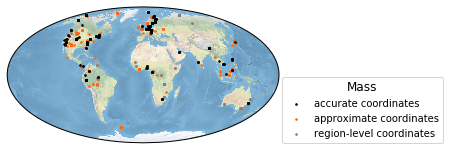

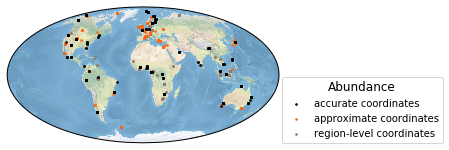

In [45]:
x = site_with_coords.loc[site_with_coords.units.str.startswith('mg')]                          
PlotScatt(x,'Mass')
plt.savefig('results/fig1_Mass.svg',dpi=600,bbox_inches = "tight")
plt.savefig('results/fig1_Mass.pdf',dpi=600,bbox_inches = "tight")

x = site_with_coords.loc[site_with_coords.units.str.startswith('ind')]                          
PlotScatt(x,'Abundance')
plt.savefig('results/fig1_ind.svg',dpi=600,bbox_inches = "tight")
plt.savefig('results/fig1_ind.pdf',dpi=600,bbox_inches = "tight")


7. Count number of distinct locations and sites

In [46]:
print('Total number of locations is %d' % site_with_coords[['lat','lon']].drop_duplicates().shape[0])
print('Total number of sites is %d' % data.site.nunique())

Total number of locations is 278
Total number of sites is 600


7. Count sites for each units used

In [47]:
print(data.groupby('units').site.nunique())
print('\n')
#data.loc[data.loc[:,'aggregated biome']=='Deserts and Xeric Shrublands'].site.nunique()
print(data.groupby('aggregated biome').site.nunique())


units
individuals/m^2        442
mg/m^2 (dry weight)    264
mg/m^2 (wet weight)    115
Name: site, dtype: int64


aggregated biome
Boreal Forests/Taiga                                             34
Crops                                                            52
Deserts and Xeric Shrublands                                     18
Flooded grasslands and savannas                                   1
Mediterranean Forests, Woodlands and Scrub                       26
Pasture                                                          51
Temperate Forests                                               115
Temperate Grasslands, Savannas and Shrublands                    39
Tropical and Subtropical Forests                                160
Tropical and Subtropical Grasslands, Savannas and Shrublands     47
Tundra                                                           81
Name: site, dtype: int64


In [48]:
site_with_coords.groupby('aggregated taxon').site.nunique()

aggregated taxon
Acari         209
Collembola    190
Formicidae    131
Isoptera      129
Other         332
Name: site, dtype: int64

In [49]:
site_with_coords.lat.max()

79.0